# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

(<matplotlib.text.Text at 0x7f0bde661390>,
 <matplotlib.text.Text at 0x7f0bde65f240>)

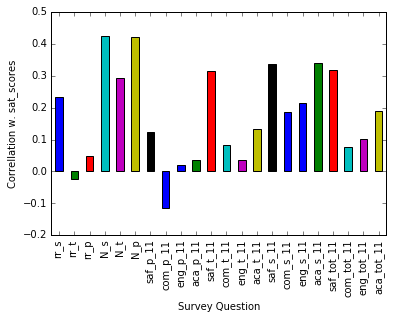

In [14]:
ax = correlations[survey_fields].plot.bar()
ax.set_xlabel('Survey Question'), ax.set_ylabel('Correllation w. sat_scores')


In this figure, we find several reasonably strong correllations between several questions from the survey and the `sat_scores` column. In particular, these questions warrant some futher investigation:

```
N_s: Number of student respondents
N_t: Number of teacher respondents
N_p: Number of parent respondents
saf_t_11: Safety and Respect score based on teacher responses
saf_s_11: Safety and Respect score based on student responses
aca_s_11: Academic expectations score based on student responses
saf_tot_11: Safety and Respect total score
```

There are also several weaker correllations present:

```
rr_s: Student Response Rate
com_s_11: Communication score based on student responses
eng_s_11: Engagement score based on student responses
aca_tot_11: Academic Expectations total score
```

Of these questions, note that `N_s`, `N_t`, and `N_p` all correllate strongly with the `total_enrollment`. Larger schools are inherently more likely to get more responses to the survey, so this indicates that the strong correllation with `sat_scores` probably has more to do with large schools performing well on the SAT, rather than the number of responses themselves having something to do with the improved scores.

(<matplotlib.text.Text at 0x7f0bde65a6d8>,
 <matplotlib.text.Text at 0x7f0bde687e80>)

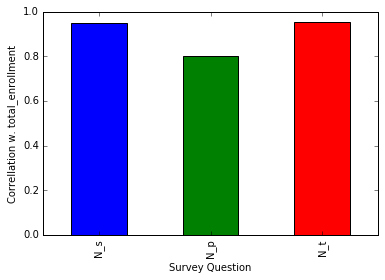

In [16]:
ax = combined.corr()['total_enrollment'][['N_s', 'N_p', 'N_t']].plot.bar()
ax.set_xlabel('Survey Question'), ax.set_ylabel('Correllation w. total_enrollment')

On the other hand, the survey response rate amongst students in particular, does appear to have a small correllation with SAT scores. This is interesting because the response *rate* is agnostic of school size and so represents new information. An initial hypothesis might be that schools with students that are more likely to engage with the survey are also more likely to be academically successful and therefore more likely to perform well on the SAT.

Another set of more strongly correllated questions are the responses by teachers and students which indicate how safe and respected they feel at school. This makes sense because learning in an unsafe enviroment is likely more stressful and difficult than a safe one (though one would have to account for socioeconomic factors as well). Finally it's worth noting that how safe *parents* feel a school is appears relatively unrelated to `sat_scores`.

Lastly, only *student* responses towards academic expectations appears to impact performance on the SAT (`aca_tot_11` is buoyed by the student responses). To a lesser extent this is also true of the other survey questions: student responses appear to be more important towards maximizing SAT scores than either parent or teacher responses.

Let's look a little deeper at two of the most significantly correllated questions: `saf_t_11` and `aca_s_11`:

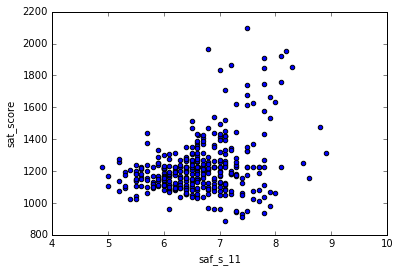

In [17]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

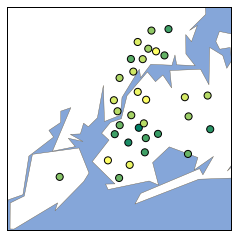

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

lons = districts["lon"].tolist()
lats = districts["lat"].tolist()
m.scatter(lons, lats, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

In this map, school districts with higher safety scores reported by students in the survey are more yellow-green to yellow, while districts reporting lower safety scores are more green to dark-green. In particular, we notice that schools with higher saftey scores tend to be in Manhattan as well as parts of the Bronx and Queens.

# Race and SAT Scores

(<matplotlib.text.Text at 0x7f0bdeedf588>,
 <matplotlib.text.Text at 0x7f0bdedaeda0>)

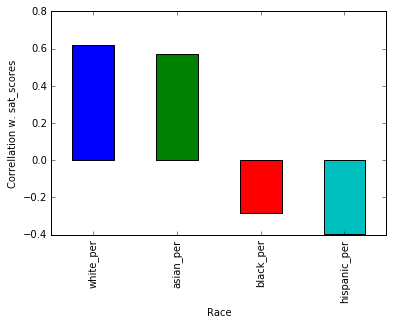

In [21]:
racial_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
ax = correlations[racial_cols].plot.bar()
ax.set_xlabel('Race (% enrollment)'), ax.set_ylabel('Correllation w. sat_scores')

Unfortunately, this plot follows an uncomfortable truth in much of American education: hispanic and black students, often attending school in low socio-economic districs, are not being educated the same. This is usually a result of school funding being tied to property taxes: schools in poorer areas recieve significantly less funding than schools in more affluent areas. This inbalance makes it difficult for them to match education spending per student, and thus students in these districts struggle. 

We can explore this issue futher by looking specifically at schools with 'low' SAT scores.

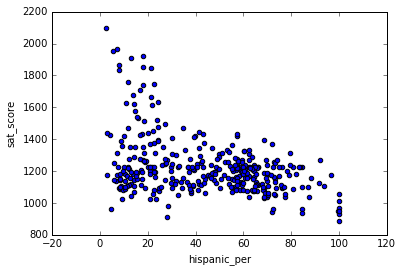

In [22]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

In [23]:
cond = (combined['hispanic_per'] > 95.) & (combined['sat_score']<combined['sat_score'].mean())
schools = combined.loc[cond, 'SCHOOL NAME']
schools.head()

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
Name: SCHOOL NAME, dtype: object

# Gender and SAT Scores

(<matplotlib.text.Text at 0x7f0bdedaba58>,
 <matplotlib.text.Text at 0x7f0bdd6b2668>)

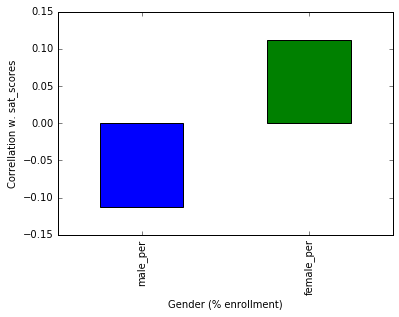

In [25]:
gender_cols = ['male_per', 'female_per']
ax = correlations[gender_cols].plot.bar()
ax.set_xlabel('Gender (% enrollment)'), ax.set_ylabel('Correllation w. sat_scores')

There is only a very weak correlation between gender and SAT performance.

# AP Exams and SAT Scores

In [26]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

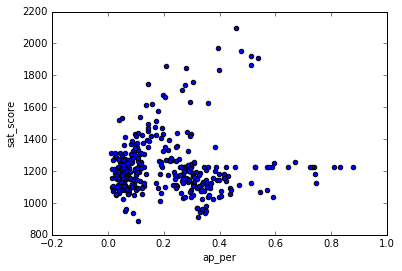

In [27]:
combined.plot.scatter(x='ap_per', y='sat_score')

We expect that there will be some positive correlation between the percentage of students taking at least one AP exam and SAT scores because these exams are meant to reflect college-level difficulty. In the scatter plot above, we can see some correlation to that effect, however it is weakened by a number of schools with very high percentage of AP test takers but moderate SAT scores. In fact, these percentages of AP test takers are suspiciously high-- in the future I would suggest validating this data further (60%+ `ap_per` in particular feels suspicious).